In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle

def get_cov_ellipse(cov, centre, nstd, eig = False, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    if eig:
        return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs), eigvals, eigvecs
    else: 
        return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)
    
def simultaneous_ci_2d(IC_1, IC_2, **kwargs):
    height = IC_2[1]-IC_2[0]
    width = IC_1[1]-IC_1[0]
    point = [IC_1[0],IC_2[0]]
    return Rectangle(point, width, height, **kwargs)

### Ví dụ 6.1 (Kiểm tra độ chênh lệch trung bình với các cặp quan sát)

In [4]:
path = '/content/drive/MyDrive/2020-2021/TKNC/Dataset/T6-1.txt'
data = pd.DataFrame(np.loadtxt(path))
print(data.head(11))

       0      1     2     3
0    6.0   27.0  25.0  15.0
1    6.0   23.0  28.0  13.0
2   18.0   64.0  36.0  22.0
3    8.0   44.0  35.0  29.0
4   11.0   30.0  15.0  31.0
5   34.0   75.0  44.0  64.0
6   28.0   26.0  42.0  30.0
7   71.0  124.0  54.0  64.0
8   43.0   54.0  34.0  56.0
9   33.0   30.0  29.0  20.0
10  20.0   14.0  39.0  21.0


In [5]:
# differences giữa các cặp quan trắc
d1 = data.loc[:,0] - data.loc[:,2]
d2 = data.loc[:,1] - data.loc[:,3]
d = np.array([d1, d2])
print("Differences of paired observations: \n",d)

# vectơ trung bình
d_mean = np.mean(d, axis=1)
print("\nMean vector d_mean: \n", d_mean)

# Ma trận hiệp phương sai
Sd = np.cov(d)
print("\nCovariance matrix Sd: \n", Sd)

Differences of paired observations: 
 [[-19. -22. -18. -27.  -4. -10. -14.  17.   9.   4. -19.]
 [ 12.  10.  42.  15.  -1.  11.  -4.  60.  -2.  10.  -7.]]

Mean vector d_mean: 
 [-9.36363636 13.27272727]

Covariance matrix Sd: 
 [[199.25454545  88.30909091]
 [ 88.30909091 418.61818182]]


In [6]:
# Ma trận nghịch đảo của Sd
invSd = np.linalg.inv(Sd)

# Tính giá trị thống kê T^2
T2 = len(data)*np.matmul(np.matmul(d_mean,invSd),np.transpose(d_mean))
print(T2)

13.639312140174688


In [7]:
alpha = 0.05
p, n = d.shape

# Giá trị tới hạn của phân phối fisher với mức ý nghĩa 0.05
f = stats.f.ppf(q=1-alpha, dfn=p, dfd=n-p)
F = (p*(n-1)/(n-p))*f
print(F)

9.458877175763888


In [8]:
lcb = lambda i: d_mean[i-1] - np.sqrt(F)*np.sqrt(Sd[i-1][i-1]/n)
ucb = lambda i: d_mean[i-1] + np.sqrt(F)*np.sqrt(Sd[i-1][i-1]/n)

# Khoảng tin cậy đồng thời với độ tin cậy 95% cho từng delta
IC_1 = np.array([lcb(1),ucb(1)])
print("95% Simultaneous confidence intervals of delta_1: \n", IC_1)

IC_2 = np.array([lcb(2),ucb(2)])
print("\n95% Simultaneous confidence intervals of delta_2: \n", IC_2)

95% Simultaneous confidence intervals of delta_1: 
 [-22.45327235   3.72599962]

95% Simultaneous confidence intervals of delta_2: 
 [-5.70011927 32.24557382]


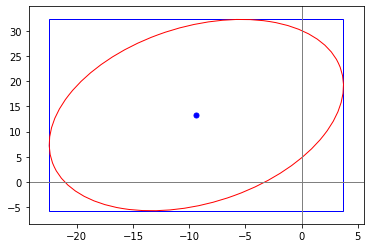

In [9]:
fig, ax = plt.subplots()

e = get_cov_ellipse(Sd, d_mean, np.sqrt(F/n), edgecolor='red', facecolor='None')
r = simultaneous_ci_2d(IC_1, IC_2, ec ='blue', fc='None')
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
ax.scatter(d_mean[0], d_mean[1], c='blue', s=25)
ax.add_patch(r)
ax.add_patch(e)

### Ví dụ 6.2 (Kiểm định sự tương đồng giữa các treatment trong repeated measures design)

In [10]:
path = '/content/drive/MyDrive/2020-2021/TKNC/Dataset/T6-2.txt'
data = np.loadtxt(path)
data = pd.DataFrame(data)
print(data.head(20))

        0      1      2      3
0   426.0  609.0  556.0  600.0
1   253.0  236.0  392.0  395.0
2   359.0  433.0  349.0  357.0
3   432.0  431.0  522.0  600.0
4   405.0  426.0  513.0  513.0
5   324.0  438.0  507.0  539.0
6   310.0  312.0  410.0  456.0
7   326.0  326.0  350.0  504.0
8   375.0  447.0  547.0  548.0
9   286.0  286.0  403.0  422.0
10  349.0  382.0  473.0  497.0
11  429.0  410.0  488.0  547.0
12  348.0  377.0  447.0  514.0
13  412.0  473.0  472.0  446.0
14  347.0  326.0  455.0  468.0
15  434.0  458.0  637.0  524.0
16  364.0  367.0  432.0  469.0
17  420.0  395.0  508.0  531.0
18  397.0  556.0  645.0  625.0


In [11]:
# vectơ trung bình
x_mean = np.array(data.apply(np.mean))
print("\nMean vector x_mean: \n", x_mean)

# Ma trận hiệp phương sai
S = np.array(np.cov(data.T))
print("\nCovariance matrix S: \n", S)


Mean vector x_mean: 
 [368.21052632 404.63157895 479.26315789 502.89473684]

Covariance matrix S: 
 [[2819.28654971 3568.41520468 2943.49707602 2295.35672515]
 [3568.41520468 7963.13450292 5303.99122807 4065.45906433]
 [2943.49707602 5303.99122807 6851.31578947 4499.64035088]
 [2295.35672515 4065.45906433 4499.64035088 4878.98830409]]


In [12]:
# contrast matrix
C = np.array([[-1,-1,1,1],[1,-1,1,-1],[1,-1,-1,1]])
print("Contrast matrix C: \n", C)

Contrast matrix C: 
 [[-1 -1  1  1]
 [ 1 -1  1 -1]
 [ 1 -1 -1  1]]


In [13]:
Cx_mean = np.matmul(C,x_mean)
CSC = np.matmul(np.matmul(C,S),np.transpose(C))
print("C.x_mean: \n", Cx_mean)
print("\nCSC': \n", CSC)

C.x_mean: 
 [209.31578947 -60.05263158 -12.78947368]

CSC': 
 [[9432.22807018 1098.90643275  927.59649123]
 [1098.90643275 5195.83040936  914.56725146]
 [ 927.59649123  914.56725146 7557.39766082]]


In [14]:
# Ma trận nghịch đảo của Sd
invCSC = np.linalg.inv(CSC)
n = data.shape[0]

# Tính giá trị thống kê T^2
T2 = n*np.matmul(np.matmul(np.transpose(Cx_mean),invCSC),Cx_mean)
print(T2)

116.01632120098769


In [15]:
alpha = 0.05
n, q = data.shape

# Giá trị tới hạn của phân phối fisher với mức ý nghĩa 0.05
f = stats.f.ppf(q=1-alpha, dfn=q-1, dfd=n-q+1)
F = ((n-1)*(q-1)/(n-q+1))*f
print(F)

10.931191371405848


In [16]:
lcb = lambda i: Cx_mean[i] - np.sqrt(F)*np.sqrt(CSC[i][i]/n)
ucb = lambda i: Cx_mean[i] + np.sqrt(F)*np.sqrt(CSC[i][i]/n)

# 95% simultaneous confidence intervals for these contrasts
IC = []
for i in range(C.shape[0]):
    ic = [lcb(i), ucb(i)]
    print("95% simultaneous confidence intervals for c'{}mu: \n{}\n".format(i+1, ic))
    IC.append(ic)

95% simultaneous confidence intervals for c'1mu: 
[135.65029726884833, 282.98128167851996]

95% simultaneous confidence intervals for c'2mu: 
[-114.72708271716843, -5.378180440726595]

95% simultaneous confidence intervals for c'3mu: 
[-78.72858439298815, 53.14963702456711]



### Ví dụ 6.3 (Xây dựng miền tin cậy cho differece giữa hai vectơ trung bình)

In [17]:
x_mean_1 = np.array([8.3, 4.1])
x_mean_2 = np.array([10.2, 3.9])
S_1 = np.array([[2, 1], [1, 6]])
S_2 = np.array([[2, 1], [1, 4]])
n1 = n2 = 50

In [18]:
S_pooled = (n1-1)/(n1+n2-2)*S_1+(n2-1)/(n1+n2-2)*S_2
x_mean = x_mean_1 - x_mean_2
print("x_mean: \n", x_mean)
print("\nS_pooled: \n",S_pooled)

x_mean: 
 [-1.9  0.2]

S_pooled: 
 [[2. 1.]
 [1. 5.]]


In [19]:
alpha =0.05
p=2
f = stats.f.ppf(q=1-alpha, dfn=p, dfd=n1+n2-p-1)
c2 = ((n1+n2-2)*p)/(n1+n2-p-1)*f
C2 = (1/n1+1/n2)*c2
print(C2)

0.24976354157952674


Eigenvalues: 
 [5.30277564 1.69722436]

Eigenvectors: 
 [[ 0.28978415 -0.95709203]
 [ 0.95709203  0.28978415]]


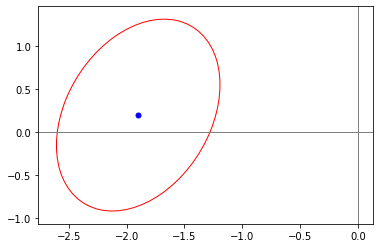

In [20]:
e, eigvals, eigvecs = get_cov_ellipse(S_pooled.T, x_mean, np.sqrt(C2), edgecolor='red', facecolor='None', eig=True)
print("Eigenvalues: \n",eigvals)
print("\nEigenvectors: \n",eigvecs)
fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
ax.scatter(x_mean[0], x_mean[1], c='blue', s=25)
ax.add_patch(e)

### Ví dụ 6.4 (Tìm khoảng tin cậy đồng thời cho differences giữa các thành phần của trung bình)

In [21]:
x_mean_1 = np.array([204.4, 556.6])
S_1 = np.array([[13825.3, 23823.4], [23823.4, 73107.4]])
n1 = 45

x_mean_2 = np.array([130.0, 355.0])
S_2 = np.array([[8632.0, 19616.7], [19616.7, 55964.5]])
n2 = 55

In [22]:
x_mean = x_mean_1 - x_mean_2
S_pooled = (n1-1)/(n1+n2-2)*S_1+(n2-1)/(n1+n2-2)*S_2
print(S_pooled)

[[10963.68571429 21505.42244898]
 [21505.42244898 63661.3122449 ]]


In [23]:
alpha = 0.05
p = 2
f = stats.f.ppf(q=1-alpha, dfn=p, dfd=n1+n2-p-1)
c2 = ((n1+n2-2)*p)/(n1+n2-p-1)*f
print(c2)

6.244088539488168


In [24]:
lcb = lambda i: x_mean[i] - np.sqrt(c2)*np.sqrt((1/n1+1/n2)*S_pooled[i][i])
ucb = lambda i: x_mean[i] + np.sqrt(c2)*np.sqrt((1/n1+1/n2)*S_pooled[i][i])

# 95% simultaneous confidence intervals for these contrasts
IC = []
for i in range(p):
    ic = [lcb(i), ucb(i)]
    print("95% simultaneous confidence intervals for mu1{}-mu2{}: \n{}\n".format(i+1, i+1, ic))
    IC.append(ic)

95% simultaneous confidence intervals for mu11-mu21: 
[21.807330725864006, 126.992669274136]

95% simultaneous confidence intervals for mu12-mu22: 
[74.86845836837189, 328.33154163162817]



Eigenvalues: 
 [71323.42597665  3301.57198254]

Eigenvectors: 
 [[ 0.33562172 -0.94199685]
 [ 0.94199685  0.33562172]]


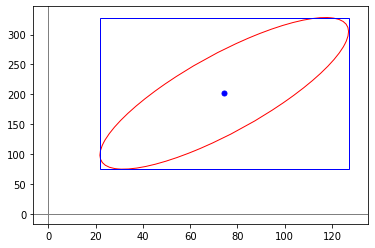

In [25]:
C2 = (1/n1+1/n2)*c2
e, eigvals, eigvecs = get_cov_ellipse(S_pooled.T, x_mean, np.sqrt(C2), edgecolor='red', facecolor='None', eig=True)
print("Eigenvalues: \n",eigvals)
print("\nEigenvectors: \n",eigvecs)
r = simultaneous_ci_2d(IC[0], IC[1], ec ='blue', fc='None')
fig, ax = plt.subplots()
ax.axvline(c='grey', lw=1)
ax.axhline(c='grey', lw=1)
ax.scatter(x_mean[0], x_mean[1], c='blue', s=25)
ax.add_patch(e)
ax.add_patch(r)

### Ví dụ 6.5 (Phương pháp mẫu lớn cho suy luận về differences trong kỳ vọng)

In [26]:
S = 1/n1*S_1 + 1/n2*S_2
print(S)

[[ 464.17434343  886.07616162]
 [ 886.07616162 2642.14525253]]


In [27]:
T2 = np.matmul(np.matmul(np.transpose(x_mean), np.linalg.inv(S)),x_mean)
print(T2)

15.658529097464301


In [28]:
alpha = 0.05
critical_value = stats.chi2.ppf(q=1-alpha, df=2)
print(critical_value)

5.991464547107979


In [29]:
a_hat = np.matmul(np.linalg.inv(S), x_mean)
a_hat

array([0.04066  , 0.0626658])

### Ví dụ 6.6 (Xấp xỉ phân phối $T^2$ khi $\boldsymbol\Sigma_1\neq\boldsymbol\Sigma_2$)

In [30]:
cS_1 = 1/n1*S_1
cS_2 = 1/n2*S_2
print("(1/n1)S1 = \n",cS_1)
print("\n(1/n2)S2 = \n",cS_2)

(1/n1)S1 = 
 [[ 307.22888889  529.40888889]
 [ 529.40888889 1624.60888889]]

(1/n2)S2 = 
 [[ 156.94545455  356.66727273]
 [ 356.66727273 1017.53636364]]


In [31]:
invS = np.linalg.inv(S)
print("Invert of S: \n",invS)

Invert of S: 
 [[ 0.00598739 -0.00200795]
 [-0.00200795  0.00105187]]


In [32]:
square_mt = lambda X: np.matmul(X,X)

A1 = np.matmul(cS_1,invS)
sqA1 = square_mt(A1)
print("(1/n1)S1[(1/n1)S1 + (1/n2)S2]^(-1) = \n", A1)
print("\n((1/n1)S1[(1/n1)S1 + (1/n2)S2]^(-1))^2 = \n", sqA1)

A2 = np.matmul(cS_2,invS)
sqA2 = square_mt(A2)
print("\n(1/n2)S2[(1/n1)S1 + (1/n2)S2]^(-1) = \n", A2)
print("\n((1/n2)S2[(1/n1)S1 + (1/n2)S2]^(-1))^2 = \n", sqA2)

(1/n1)S1[(1/n1)S1 + (1/n2)S2]^(-1) = 
 [[ 0.77647483 -0.06002961]
 [-0.09234853  0.64585273]]

((1/n1)S1[(1/n1)S1 + (1/n2)S2]^(-1))^2 = 
 [[ 0.60845681 -0.08538177]
 [-0.13134985  0.42266939]]

(1/n2)S2[(1/n1)S1 + (1/n2)S2]^(-1) = 
 [[0.22352517 0.06002961]
 [0.09234853 0.35414727]]

((1/n2)S2[(1/n1)S1 + (1/n2)S2]^(-1))^2 = 
 [[0.05550715 0.03467745]
 [0.0533472  0.13096394]]


In [33]:
a1 = 1/n1*(np.matrix.trace(sqA1)+np.matrix.trace(A1)**2)
a2 = 1/n2*(np.matrix.trace(sqA2)+np.matrix.trace(A2)**2)
print("\n", a1)
print("\n", a2)


 0.06786981982503869

 0.009457755109839696


In [34]:
p = 2
v = (p + p**2)/(a1 + a2)
print("Estimated d.f v = ", v)

Estimated d.f v =  77.5919845547066


In [35]:
alpha = 0.05
f = stats.f.ppf(q=1-alpha, dfn=p, dfd=v-p+1)
c2 = ((v*p)/(v-p+1))*f
print("The critical value: ", c2)

The critical value:  6.313406609436417


### Ví dụ 6.7 (Tổng bình phương phân rã cho ANOVA một chiều)

In [36]:
population1_1 = [9,6,9]
population2_1 = [0,2]
population3_1 = [3,1,2]
data_1 = pd.DataFrame([population1_1, population2_1, population3_1])
print(data_1)

   0  1    2
0  9  6  9.0
1  0  2  NaN
2  3  1  2.0


In [37]:
df_1 = data_1.copy()
df_1['mean_j'] = df_1.mean(axis=1)
group_mean_1 = df_1.groupby("mean_j",sort=False).mean().stack().reset_index().rename(columns={0:'value'})
group_mean_1 = group_mean_1.drop(group_mean_1.columns[1],axis=1)
x_mean_1 = group_mean_1['value'].mean()
group_mean_1["mean"]=float(x_mean_1)
print(group_mean_1)

   mean_j  value  mean
0     8.0    9.0   4.0
1     8.0    6.0   4.0
2     8.0    9.0   4.0
3     1.0    0.0   4.0
4     1.0    2.0   4.0
5     2.0    3.0   4.0
6     2.0    1.0   4.0
7     2.0    2.0   4.0


In [40]:
residual_1 = pd.DataFrame(np.transpose([df_1[i]-df_1["mean_j"] for i in range(data_1.shape[0])]))
print(residual_1)
residual_1 = residual_1.stack().reset_index().drop(['level_0', 'level_1'],axis=1).rename(columns={0:'value'})

     0    1    2
0  1.0 -2.0  1.0
1 -1.0  1.0  NaN
2  1.0 -1.0  0.0


In [41]:
SS_obs_1 = np.sum(group_mean_1['value'].values**2)
SS_obs_1

216.0

In [42]:
SS_mean_1 = np.sum(group_mean_1["mean"].values**2)
SS_mean_1

128.0

In [43]:
SS_tr_1 = np.sum((group_mean_1["mean_j"]-group_mean_1["mean"]).values**2)
SS_tr_1

78.0

In [44]:
SS_res_1 = np.sum(residual_1['value'].values**2)
SS_res_1

10.0

### Ví dụ 6.8 (Bảng ANOVA một chiều và kiểm định F cho treatment effects)

In [45]:
SS_cor_1 = np.sum((group_mean_1['value']-group_mean_1['mean']).values**2)
print("Sum of squares of treatment: ", SS_tr_1)
print("\nSum of squares of residual: ", SS_res_1)
print("\nSum of squares of total: ", SS_cor_1)

Sum of squares of treatment:  78.0

Sum of squares of residual:  10.0

Sum of squares of total:  88.0


In [46]:
g = data_1.shape[0]
n = data_1.count(axis=1)
df_tr_1 = g - 1
df_res_1 = np.sum(n) - g
df_cor_1 = np.sum(n) - 1
print("df of treatment: ", df_tr_1)
print("\ndf of residual: ", df_res_1)
print("\ndf of total: ", df_cor_1)

df of treatment:  2

df of residual:  5

df of total:  7


In [47]:
F = (SS_tr_1/df_tr_1)/(SS_res_1/df_res_1)
F

19.5

In [48]:
alpha = 0.01
f = stats.f.ppf(q=1-alpha, dfn=df_tr_1, dfd=df_res_1)
f

13.273933612004825

### Ví dụ 6.9: (Bảng MANOVA và số lambda của Wilk về kiểm định tính bằng nhau của 3 véctơ trung bình

In [49]:
population1_2 = [3,2,7]
population2_2 = [4,0]
population3_2 = [8,9,7]
data_2 = pd.DataFrame([population1_2, population2_2, population3_2])

df_2 = data_2.copy()
df_2['mean_j'] = df_2.mean(axis=1)
group_mean_2 = df_2.groupby("mean_j",sort=False).mean().stack().reset_index().rename(columns={0:'value'})
group_mean_2 = group_mean_2.drop(group_mean_2.columns[1],axis=1)
x_mean_2 = group_mean_2['value'].mean()
group_mean_2["mean"]=float(x_mean_2)

residual_2 = pd.DataFrame(np.transpose([df_2[i]-df_2["mean_j"] for i in range(data_2.shape[0])]))
residual_2 = residual_2.stack().reset_index().drop(['level_0', 'level_1'],axis=1).rename(columns={0:'value'})

SS_obs_2 = np.sum(group_mean_2['value'].values**2)
SS_mean_2 = np.sum(group_mean_2["mean"].values**2)
SS_tr_2 = np.sum((group_mean_2["mean_j"]-group_mean_2["mean"]).values**2)
SS_res_2 = np.sum(residual_2['value'].values**2)
SS_cor_2 = np.sum((group_mean_2['value']-group_mean_2['mean']).values**2)

In [50]:
print("All values in univariate ANOVA for second variable:\n")
print("- Observations with mean: \n", group_mean_2)
print("\n- Residual: \n",residual_2)
print("\n- Sum of squares of observations: ", SS_obs_2)
print("\n- Sum of squares of mean: ", SS_mean_2)
print("\n- Sum of squares of treatment: ", SS_tr_2)
print("\n- Sum of squares of residual: ", SS_res_2)
print("\n- Sum of squares of total: ", SS_cor_2)

All values in univariate ANOVA for second variable:

- Observations with mean: 
    mean_j  value  mean
0     4.0    3.0   5.0
1     4.0    2.0   5.0
2     4.0    7.0   5.0
3     2.0    4.0   5.0
4     2.0    0.0   5.0
5     8.0    8.0   5.0
6     8.0    9.0   5.0
7     8.0    7.0   5.0

- Residual: 
    value
0   -1.0
1   -2.0
2    3.0
3    2.0
4   -2.0
5    0.0
6    1.0
7   -1.0

- Sum of squares of observations:  272.0

- Sum of squares of mean:  200.0

- Sum of squares of treatment:  48.0

- Sum of squares of residual:  24.0

- Sum of squares of total:  72.0


In [55]:
# Nhân từng dòng của các ma trận tương ứng của hai biến
group_mean_3 = group_mean_1.multiply(group_mean_2)
print(group_mean_3)
residual_3 = residual_1.multiply(residual_2)
print(residual_3)

   mean_j  value  mean
0    32.0   27.0  20.0
1    32.0   12.0  20.0
2    32.0   63.0  20.0
3     2.0    0.0  20.0
4     2.0    0.0  20.0
5    16.0   24.0  20.0
6    16.0    9.0  20.0
7    16.0   14.0  20.0
   value
0   -1.0
1    4.0
2    3.0
3   -2.0
4   -2.0
5    0.0
6   -1.0
7   -0.0


In [56]:
S_obs_3 = np.sum(group_mean_3['value'].values)
S_mean_3 = np.sum(group_mean_3["mean"].values)
S_tr_3 = np.sum((group_mean_3["mean_j"]-group_mean_3["mean"]).values)
S_res_3 = np.sum(residual_3['value'].values)
S_cor_3 = np.sum((group_mean_3['value']-group_mean_3['mean']).values)

print("\n- Sum of observations: ", S_obs_3)
print("\n- Sum of mean: ", S_mean_3)
print("\n- Sum of treatment: ", S_tr_3)
print("\n- Sum of residual: ", S_res_3)
print("\n- Sum of total: ", S_cor_3)


- Sum of observations:  149.0

- Sum of mean:  160.0

- Sum of treatment:  -12.0

- Sum of residual:  1.0

- Sum of total:  -11.0


In [116]:
B = np.array([[SS_tr_1, S_tr_3],[S_tr_3, SS_tr_2]])
W = np.array([[SS_res_1, S_res_3],[S_res_3, SS_res_2]])

print("W = ", W)
print("\nB = ", B)

W =  [[10.  1.]
 [ 1. 24.]]

B =  [[ 78. -12.]
 [-12.  48.]]


In [118]:
Lambda = np.linalg.det(W)/np.linalg.det(B+W)
Lambda

0.0384553499597747

In [119]:
p = 2
g = 3
((1-np.sqrt(Lambda))/np.sqrt(Lambda))*((np.sum(n)-g-1)/(g-1))

8.198859563778381

In [121]:
alpha = 0.01
v1 = 2*(g-1)
v2 = 2*(np.sum(n)-g-1)
f = stats.f.ppf(q=1-alpha, dfn=v1, dfd=v2)
f

7.006076622955586

### Ví dụ 6.10 (Phân tích nhiều biến cho dữ liệu viện dưỡng lão Wisconsin)

In [154]:
p = 4
g = 3
n1 = 271
n2 = 138
n3 = 107
n = n1+n2+n3
x1_mean = np.array([2.066, .480, .082, .360])
x2_mean = np.array([2.167, .596, .124, .418])
x3_mean = np.array([2.273, .521, .125, .383])
S1 = np.array([[.291, -.001, .002, .010], [-.001, .011, .000, .003], [.002, .000, .001, .000], [.010, .003, .000, .010]])
S2 = np.array([[.561, .011, .001, .037], [.011, .025, .004, .007], [.001, .004, .005, .002], [.037, .007, .002, .019]])
S3 = np.array([[.261, .030, .003, .018], [.030, .017, -.000, .006], [.003, -.000, .004, .001], [.018, .006, .001, .013]])

In [140]:
W = (n1-1)*S1 + (n2-1)*S2 + (n3-1)*S3
W

array([[183.093,   4.417,   0.995,   9.677],
       [  4.417,   8.197,   0.548,   2.405],
       [  0.995,   0.548,   1.379,   0.38 ],
       [  9.677,   2.405,   0.38 ,   6.681]])

In [141]:
x_mean = (n1*x1_mean + n2*x2_mean + n3*x3_mean)/n
x_mean = x_mean[:, np.newaxis]
x_mean

array([[2.13593605],
       [0.51952519],
       [0.10214922],
       [0.38028101]])

In [142]:
B1 = n1*np.matmul((x1_mean[:, np.newaxis] - x_mean),np.transpose((x1_mean[:, np.newaxis] - x_mean)))
B2 = n2*np.matmul((x2_mean[:, np.newaxis] - x_mean),np.transpose((x2_mean[:, np.newaxis] - x_mean)))
B3 = n3*np.matmul((x3_mean[:, np.newaxis] - x_mean),np.transpose((x3_mean[:, np.newaxis] - x_mean)))
B = B1 + B2 + B3
B

array([[3.46879889, 1.09857133, 0.81067792, 0.58595027],
       [1.09857133, 1.23067867, 0.45003356, 0.61573385],
       [0.81067792, 0.45003356, 0.23178351, 0.23112936],
       [0.58595027, 0.61573385, 0.23112936, 0.30859425]])

In [143]:
Lambda = (np.linalg.det(W))/(np.linalg.det(B+W))
Lambda

0.7627582047406533

In [152]:
((n-p-2)/p)*((1-np.sqrt(Lambda))/np.sqrt(Lambda))

18.48785946853036

In [153]:
alpha = 0.01
v1 = 2*p
v2 = 2*(np.sum(n)-g-2)
f = stats.f.ppf(q=1-alpha, dfn=v1, dfd=v2)
f

2.5286474809091057

In [155]:
-(n-1-(p+g)/2)*np.log(Lambda)

138.5214626117343